In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

from functools import partial

from theano import shared, function, scan
import theano.tensor as tt
from theano.tensor import slinalg
from theano.tensor.nlinalg import matrix_inverse
cholesky = slinalg.cholesky

from pymc3 import Model, sample, Metropolis, advi, Deterministic, Mixture, generator
from pymc3 import DensityDist, CategoricalGibbsMetropolis, Minibatch, logsumexp
from pymc3.distributions import *
from pymc3.gp import cov, gp, mean
from pymc3 import advi, adam, fit

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
bmi_by_patient = (pd.read_csv(DATA_DIR+'bmi_by_patient.csv', index_col=0)
                      .dropna(axis=1, thresh=5))
bmi_by_patient.head()

,1621101,1685338,1713205,1958537,2025534,2062537,2087799,2129427,2186450,2382232,...,40985475,41005570,41014622,41014655,41043167,41052325,41054388,41077231,41087032,41248451
Days,,,,,,,,,,,,,,,,,,,,,
0,0,0,0.000,0.00,0,NaN,0.00,0,0.0,0,...,0.0000,0.00,0,0,0.000,0.00,0.000000,0.000,NaN,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,29.785761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.695456
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,29.969401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.209745
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,29.030746,NaN,NaN,NaN,NaN,NaN,NaN,28.695456
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


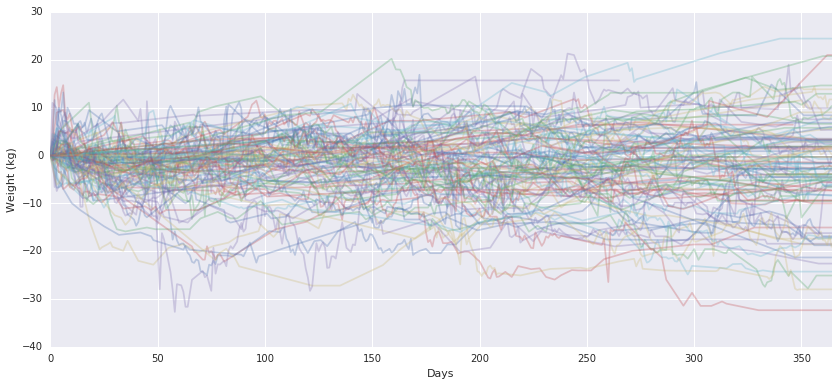

In [3]:
bmi_resampled = bmi_by_patient.resample('2W').mean()
bmi_resampled.shape

In [6]:
# data_subset = bmi_resampled.iloc[:, :500]
data_subset = bmi_resampled.copy()

Random sample of 100 trajectories

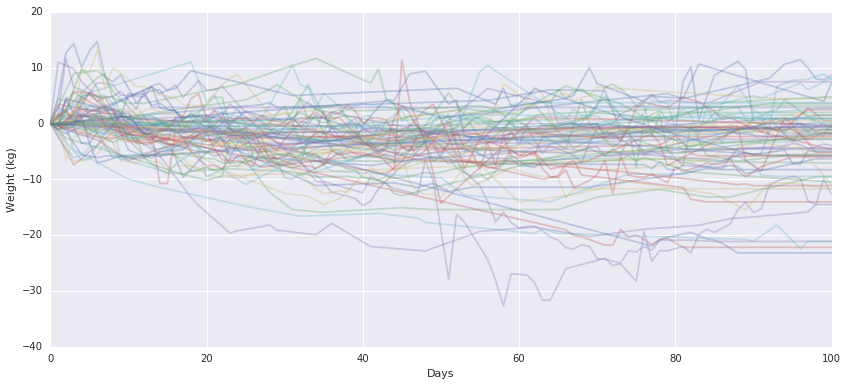

In [5]:
fig, axes = plt.subplots(figsize=(14,6))
(bmi_resampled[np.random.choice(bmi_resampled.columns, 100)].interpolate(limit=10)
            .plot(legend=False, alpha=0.3, ax=axes))
axes.set_ylabel('BMI');

In [6]:
data_subset.shape

(27, 5915)

Stick-breaking function for Dirichlet process

In [9]:
def stick_breaking(beta):
    
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

Maximum number of groups

In [10]:
CLUSTERS = 20
D, N = data_subset.shape

In [11]:
data_missing = np.ma.masked_equal(data_subset.fillna(42).values, 42).T

In [10]:
with Model() as model:
        
    # DP concentration parameter
    α = Gamma('α', 1., 1.)
    # Stick-breaking components
    β = Beta('β', 1., 1, shape=CLUSTERS)
    ω = Deterministic('ω', stick_breaking(β))
    
    # Hyperparameters of GPs
    η = HalfCauchy('η', 3, shape=CLUSTERS)
    ρ = HalfCauchy('ρ', 3, shape=CLUSTERS)
    # Noise
    σ = HalfCauchy('σ', 5)
    
    # Covariance functions for each component
    K = [η[c]*cov.Matern32(1, ρ[c]) for c in range(C)]
            
    for i,data in enumerate(minibatches.data):
        
        s = tt.eye(D)*(σ**2)
        
        # Mixture of Gaussian processes
        gp_logp, _ = scan(calc_logp, sequences=[value], non_sequences=[s])
        
        return tt.sum(logsumexp(tt.log(ω) + gp_logp, axis=-1))
        
    trajectories = DensityDist('trajectories', logp, observed=minibatches, 
                               shape=(BATCH_SIZE, D), total_size=data_missing.shape)
        

In [ ]:
with model:
    adam = partial(adam, learning_rate=.8) # easy problem
    approx = fit(10000, method='advi', obj_optimizer=adam)

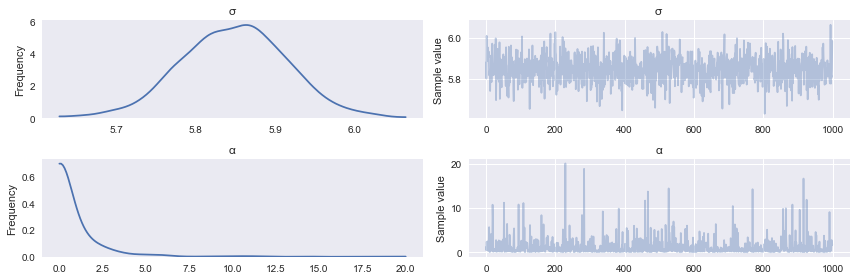

In [64]:
traceplot(trace, varnames=['σ', 'α']);

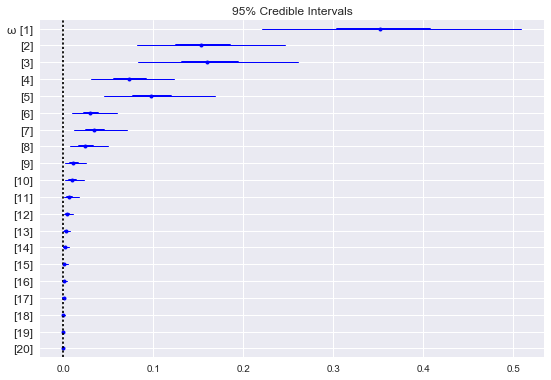

In [28]:
forestplot(trace, varnames=['ω'])

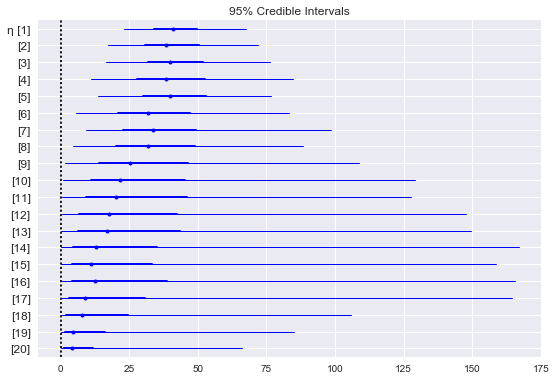

In [29]:
forestplot(trace, varnames=['η'])

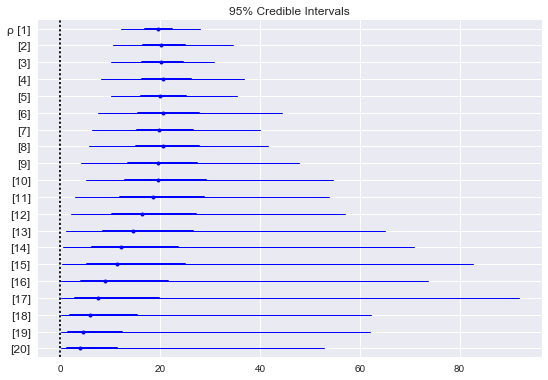

In [30]:
forestplot(trace, varnames=['ρ'])

In [48]:
with model:
    posterior_samples = sample_ppc(trace, 100, vars=[η, ρ, σ])

100%|██████████| 100/100 [00:00<00:00, 147.98it/s]


In [49]:
eta = posterior_samples['η']
sigma = posterior_samples['σ']
rho = posterior_samples['ρ']